This notbook is inspired on Andrej Karpathy's youtube lecture about micrograd. Available on https://www.youtube.com/watch?v=VMj-3S1tku0&t=5128s 

In [219]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [220]:
# This is a data structure that will be used for the neural newtworks and its operations
class Value:

    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children) # Children are supposed to be tuples. _prev represents the previous value before the last operation
        self.grad = 0 # The derivative, which starts at 0. As a derivative, 0 means that there is no change
        self._op = _op # Operation symbol
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        # Defining these operators with these __xxx__
        other = other if isinstance(other, Value) else Value(other) # If it is an instance of value, we'll wrap in the value. This way we can add numbers like a + 2
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1 * out.grad # It's a 1 as this is a plus operation
            other.grad += 1 * out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other):
        # This is needed for the rest of the operations to recognize the "-" signal
        other = other if isinstance(other, Value) else Value(other) # If it is an instance of value, we'll wrap in the value. This way we can subtract numbers like a - 2
        out = Value(self.data - other.data, (self, other), '-')

        def _backward():
            self.grad += 1 * out.grad
            other.grad += -1 * out.grad # It's a -1 as this is a subtraction operation
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # This way we can multiply numbers like a * 2
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # Chain rule
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad # d(exp)/dx = x * e ** (x-1)
        out._backward = _backward

        return out


    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other): # self / other #  Division is the same thing as multiplying by a -1 exponential
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # t is tanh
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad # Chain rule
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
    
        return out
    
    def backward(self):
        topo = []
        visited = set() # visited nodes
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev: # iterates through all the children of the node
                    build_topo(child)
                topo.append(v) # It only adds the node itself after going through all the children

        build_topo(self)

        self.grad = 1
        # This makes what we did manually, going from the end to the beginning
        for node in reversed(topo):
            node._backward()    

In [221]:
# Just for visualization
import graphviz 
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [222]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

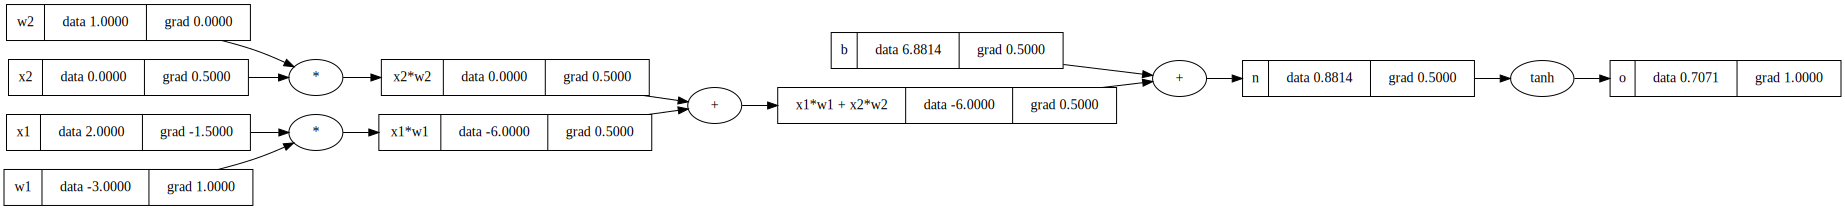

In [223]:
draw_dot(o)

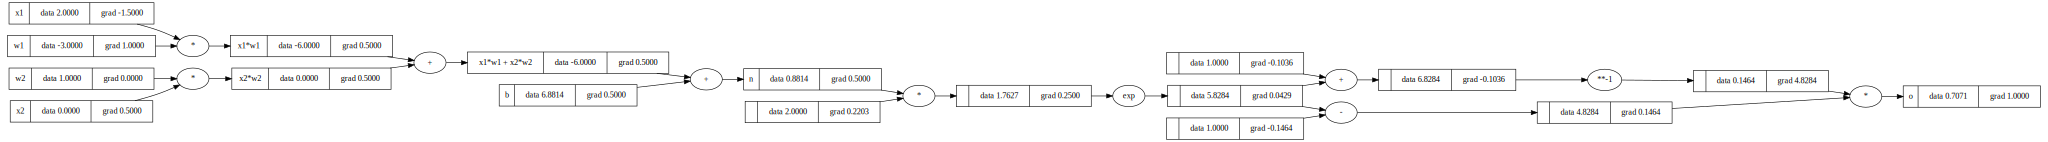

In [224]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [226]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True # By casting to double python converts it into float
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True # Typically you don't need the grad in leaf nodes as it is not as efficient doing this way
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [227]:
o.item()

0.7071066904050358

In [228]:
x2.grad.item() # Torch has the backward pass that calculates the gradient as it was done manually

0.5000001283844369

# Neuron visualization

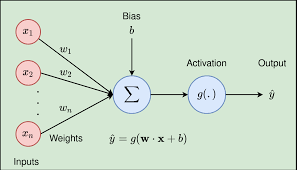

In [229]:
# Building a neuron class

class Neuron: 
    def __init__(self, nin): # n_instances
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # A neuron has the weights and the bias. Receives the nin inputs from the previous neurons and every connection to the previous neurons has a weight attached to them
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # W * x +b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # act is short for activation
        out = act.tanh()
        return out
    
    def parameters(self): # Parameters of the neuron (pytorch also has this option)
        return self.w + [self.b]


In [230]:
# A single neuron
x = [2,3]
n = Neuron(2)
n(x)

Value(data = 0.8691296013817744)

A list of neurons, a Layer

In [231]:
class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs # This allows to just get a single value out in the final layer that only has 1 neuron


    def parameters(self):
        # params = []

        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)

        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()] # Same thing as the code before, but simplified
    

In [232]:
x = [2, 3]
n = Layer(2, 3)
n(x)

[Value(data = -0.9155995008010954),
 Value(data = 0.9735130778427568),
 Value(data = -0.9149008753821353)]

A list of Layers, a multi layer perceptron, MLP

In [233]:
class MLP:
  
  def __init__(self, nin, nouts): # number of inputs (neurons of the input layer), number of outputs. The nouts is a list, which represent the sizes of the layers
    sz = [nin] + nouts # Sizes of the layers as a list
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # Each layer receives the number of inputs and outputs. Iterates in pairs where the outputs of x are the inputs of x + 1
  
  def __call__(self, x): # This just calls them sequentially
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [234]:
x = [2, 3, -1]
n = MLP(3, [4,4,1]) # 3 neurons in the  input layer, 4 neurons in the intermediate layer and 1 neuron in the output layer
n(x)

Value(data = 0.7995763511884536)

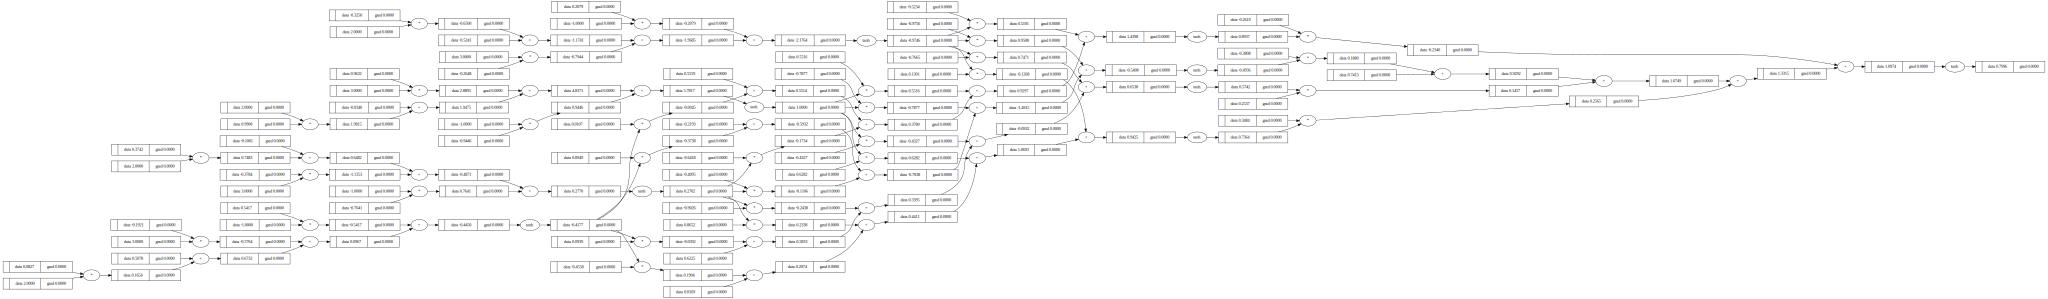

In [235]:
draw_dot(n(x))

# Basic classifier neural net

In [236]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [237]:
ypred = [n(x) for x in xs]
ypred # With no training

[Value(data = 0.7995763511884536),
 Value(data = 0.6146310981615427),
 Value(data = 0.21164710917618232),
 Value(data = 0.7868778655549142)]

In [238]:
# Loss measures how well the neural net is performing
# MSE loss: The squared makes sure that whether it is negative or positive, it always gets a positive number
# Initialize the loss with a zero Value object
loss = Value(0.0)

# Perform the summation
for ygt, yout in zip(ys, ypred): # ygt: y ground truth
    loss += (yout - ygt)**2 
    
loss

Value(data = 4.160712983518711)

In [239]:
loss.backward()

In [240]:
n.layers[0].neurons[0].w

[Value(data = 0.08267568761667232),
 Value(data = -0.19213677475371282),
 Value(data = 0.5417096250217044)]

In [241]:
n.layers[0].neurons[0].w[0].grad # Derivative of the first weight of the first neuron of the the first layer

-0.6917207716045288

In [242]:
# draw_dot(loss)

In [243]:
n.layers[0].neurons[0].w[0].data 

0.08267568761667232

In [244]:
n.parameters()

[Value(data = 0.08267568761667232),
 Value(data = -0.19213677475371282),
 Value(data = 0.5417096250217044),
 Value(data = 0.5078074515350093),
 Value(data = 0.37415972331879077),
 Value(data = -0.3784372375279075),
 Value(data = -0.7641119918956412),
 Value(data = -0.10007686183003628),
 Value(data = 0.9907513648717241),
 Value(data = 0.963169123992131),
 Value(data = -0.9446036703091099),
 Value(data = -0.03395974963197301),
 Value(data = -0.32500547076198694),
 Value(data = -0.26480340985605433),
 Value(data = 0.20786240854538574),
 Value(data = -0.5240765660044282),
 Value(data = 0.8948520870829602),
 Value(data = -0.4095257434749615),
 Value(data = -0.7877348415218748),
 Value(data = -0.9755770541629485),
 Value(data = -0.21934912080435898),
 Value(data = 0.093853235296401),
 Value(data = -0.9025849097279606),
 Value(data = -0.4327273450215192),
 Value(data = -0.7665471311408163),
 Value(data = 0.6225426803927163),
 Value(data = -0.4558459118885472),
 Value(data = 0.865218480057556

Now the following 4 cells can be run in loop continuously, which would represent what training is

In [314]:
for p in n.parameters():
    p.data += -0.01*p.grad # If you make a too big of a step the training becomes unstable

In [315]:
ypred = [n(x) for x in xs]
loss = Value(0.0)

# Perform the summation
for ygt, yout in zip(ys, ypred): # ygt: y ground truth
    loss += (yout - ygt)**2 
    
loss

Value(data = 6.8487417427817735e-06)

In [316]:
ypred

[Value(data = 0.9980170400747593),
 Value(data = -0.9999953797027848),
 Value(data = -0.9998669623672584),
 Value(data = 0.9982973869145342)]

In [317]:
loss.backward()

To do this on a single cell for other values:

In [330]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

n = MLP(4, [5,4,3, 1]) # 5 neurons in the  input layer, 4 neurons in the second layer, 3 on the third layer and 1 neuron in the output layer
n(x)

Value(data = -0.26499265649591325)

# Explaining the training loop

1 - The forward pass calculates the loss between the desired and the predicted outputs.

2 - For every parameter the grad is set to 0, and then beggining at the loss (which is calculated as the last step of the neural network), it goes backwards from the end until the beggining, calculating the derivatives at each parameter.

3 - New weights for every parameter are calculated by multiplying the learning rate and the gradient that was calculated in step 2

4 - Repeat this for X iterations

In [331]:
for k in range(200):
  
  # forward pass
  ypred = [n(x) for x in xs]
  print('predictions: ', ypred)
  loss = Value(0.0)
  for ygt, yout in zip(ys, ypred): # ygt: y ground truth
    loss += (yout - ygt)**2 
  
  # backward pass
  for p in n.parameters():
    # Something that was forgotten earlier, setting the parameters gradient to 0 for every iteration
    p.grad = 0.0    # We have to flush the grad otherwise it will iterate over and over instead of doind the derivate in every iteration. It is important to note the the .grad objects are defined as += so if it is not flushed as .grad=0, it would just keep on adding
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.01 * p.grad # The 0.01 is the learning rate
  
  print(k, loss.data)

predictions:  [Value(data = -0.26499265649591325), Value(data = -0.3166604508770152), Value(data = -0.5330790009740145), Value(data = -0.009369610660644527)]
0 3.304001590640837
predictions:  [Value(data = -0.16531451357384455), Value(data = -0.2502819138237508), Value(data = -0.5209709813226263), Value(data = 0.08657693735308711)]
1 2.983845616395897
predictions:  [Value(data = -0.07783254819118164), Value(data = -0.2003330175922934), Value(data = -0.5194037459190477), Value(data = 0.1653154163064554)]
2 2.7288613983856522
predictions:  [Value(data = -0.0038062240432763044), Value(data = -0.16763795053325933), Value(data = -0.5267401398044699), Value(data = 0.2287712865705229)]
3 2.5192221405108723
predictions:  [Value(data = 0.058238726069719096), Value(data = -0.1510439815227531), Value(data = -0.5403099260033964), Value(data = 0.28014186512658923)]
4 2.3371513168579536
predictions:  [Value(data = 0.11080505237305525), Value(data = -0.1487199411958962), Value(data = -0.5574837250024